### Importation et configuration du notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import sys

sys.path.insert(0, os.path.abspath('..'))

import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow_probability as tfp
tfd = tfp.distributions

from recast.distributions import *
from recast.etas import *
from recast.model import *

sns.set_style('whitegrid')

### Fonctions d'assistance

In [12]:
def poisson(T: float, mu: float) -> list[float]:
    """Génère un processus de Poisson homogène."""
    N = np.random.poisson(mu * T)
    return np.sort(np.random.uniform(0, T, size=N))


def poisson_inh(T: float, mu: float = 1) -> list[float] | None:
    """Génère un processus de Poisson inhomogène."""
    intensity = lambda t: 1 + np.sin(0.1 * t)
    x = np.linspace(0, T, 1000)
    sup = np.max(intensity(x))

    times = np.array([-1 / mu * np.log(np.random.uniform())])

    while times[-1] < T:
        tau = -1 / mu * np.log(np.random.uniform())
        next_time = times[-1] + tau
        D = np.random.uniform()
        if D <= intensity(next_time) / sup:
            times = np.append(times, next_time)

    return times[times <= T]


def intensity(t: float, seq: np.ndarray, mu: float = 1,
              alpha: float = 2, beta: float = 2.3) -> float:
        return mu + np.sum(alpha * np.exp(-beta * (t - seq[seq < t])))


def hawkes(mu: float = 1, alpha: float = 1, beta: float = 2,
           T: float = 100) -> list[float] | None:
    """Génère un processus de Hawkes."""
    times = np.array([-1 / mu * np.log(np.random.uniform())])

    if times.size == 0:
        return None

    while times[-1] < T:
        lambd_bar = intensity(times[-1], times, mu, alpha, beta)
        tau = -1 / lambd_bar * np.log(np.random.uniform())
        next_time = times[-1] + tau
        D = np.random.uniform()
        if D * lambd_bar <= intensity(next_time, times, mu, alpha, beta):
            times = np.append(times, next_time)

    return times[times <= T]


def cmp_dist(model: Model, seq: np.ndarray, start: int,
             ylim: tuple[float, float] = (0, 1)) -> None:
    """Compare les distributions ETAS et RECAST."""
    sub_seq = seq[:start]
    t = sub_seq[:, 0]
    m = sub_seq[:, 1]
    recast_dist = model.predict(t, m, 1, True)[1][0]
    etas_dist = ETAS(t, m)
    fig, axes = plt.subplots(2, 1, sharex='col', sharey='col', figsize=(6, 3))
    x = np.linspace(0, 3, 1000)
    axes[0].plot(x, recast_dist.prob(x), label='RECAST')
    axes[1].plot(x, etas_dist.prob(x), label='ETAS')
    axes[1].set_ylim(ylim)
    plt.show()


def plot_etas_seq(seq: pd.DataFrame, n: int = 0,
                  dpi: Optional[int] = None) -> None:
    """Affiche la séquence et les n plus grandes magnitudes."""
    fig, ax = plt.subplots(figsize=(6, 4), dpi=dpi)
    ax.plot(seq.time, seq.index + 1)
    high_mags_idx = seq.magnitude.sort_values(ascending=False).index[:n]
    for idx in high_mags_idx:
        t = seq.time.iloc[idx]
        m = seq.magnitude.iloc[idx]
        ax.scatter(t, idx + 1, label=f'{m:.2f}', marker='.', s=100)
        ax.vlines(t, 0, idx + 1, linestyle='--', alpha=0.5, colors='black')
    if n:
        ax.legend(loc='upper left', ncol=2)
    plt.show()


def get_seq(generated_data: np.ndarray, seq_lengths: np.ndarray,
            i: int) -> pd.DataFrame:
    """Retourne un tableau pandas qui contient les données générées."""
    arrival_times = generated_data[i, :seq_lengths[i], 0]
    magnitudes = generated_data[i, :seq_lengths[i], 1]
    seq = pd.DataFrame({'time': arrival_times, 'magnitude': magnitudes})
    return seq


def plot_seqs(seqs: list[np.ndarray]):
    for seq in seqs:
        plt.plot(seq[:, 0], np.cumsum(np.ones(seq.shape[0])))
    plt.show()


def cumsum(arr: np.ndarray) -> np.ndarray:
    return np.cumsum(np.ones_like(arr))


def predict_and_plot(model: Model, seq: np.ndarray, n_before: int,
                     n_after: Optional[int] = None,
                     dpi: Optional[int] = None) -> np.ndarray:
    """Affiche la nouvelle séquence avec les données prédites."""
    n_preds = n_after if n_after else n_before
    past_seq = seq[:-n_before]
    t = past_seq[:, 0]
    m = past_seq[:, 1]
    preds = model.predict(t, m, n_preds)
    t_preds = preds[:, 0]
    m_preds = preds[:, 1]
    seq_size = seq.shape[0]
    last_idx_target = min(seq_size - 1, seq_size - n_before + n_preds)
    t_targets = seq[-n_before:last_idx_target, 0]

    fig, ax = plt.subplots(dpi=dpi)
    ax.plot(t, cumsum(t), label='Séquence passée')
    ax.plot(t_preds, t.size + cumsum(t_preds), label='Prédictions', alpha=0.6)
    ax.plot(t_targets, t.size + cumsum(t_targets), label='Cibles', alpha=0.6)
    ax.axhline(y=t.size, linestyle='--', c='black', alpha=0.7)
    ax.legend()
    plt.show()

    new_seq = np.concatenate([past_seq[:, :2], preds], 0)
    return new_seq


def get_dist_at_epoch(i: int, dists: list[Mixture],
                      dist: Distribution = Weibull) -> Mixture:
    weights, params = dists[i].params
    weights = weights[0, 250]
    b = params[..., 0][0, 250]
    k = params[..., 1][0, 250]
    return Mixture(weights, dist(b, k))


def sgd(F, x_train, y_train, theta_0, lr, n_step):
    grad_F = jax.grad(F, argnums=1)

    thetas = [theta_0]

    for t in range(n_step):
        idx = np.random.randint(len(x_train))
        y_pred = F(x_train[idx], theta_0)
        loss = (y_train[idx] - y_pred) ** 2
        grads = grad_F(loss, theta_0)
        theta_0 -= lr * grads
        thetas.append(theta_0)

    return thetas


def data_generation():
    a, b = 3.3, -3.1

    def true_f(x):
        return x * jnp.exp(-(x - b) ** 2 /2 ) + jnp.exp(-(x - a) ** 2 / 2)

    n = 500
    x_train = np.random.uniform(low=-10, high=10, size=n)
    y_train = true_f(x_train) + 0.1 * np.random.randn(n)
    
    return x_train, y_train


def plot_sgd(F, x_train, y_train, thetas):
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))

    thetas = np.array(thetas)

    ax = axs[0]

    ax.plot(thetas[:, 0], thetas[:, 1],
            label=r'Mise à jour des $\theta$', zorder=1)
    ax.scatter(thetas[0, 0], thetas[0, 1], c='black', s=150,
               label='Départ', zorder=2)
    ax.scatter(thetas[-1][0], thetas[-1][1], c='blue', s=150,
               label='Arrivée', zorder=2)
    ax.scatter([3.3], [-3.1], label='Objectif', s=150)
    ax.grid()
    ax.legend()

    xs = np.linspace(-10, 10, 500)

    ax = axs[1]
    ax.scatter(x_train, y_train, label='Données d\'entraînement', s=10)
    ax.plot(xs, F(xs, thetas[0]), c='red', linewidth=3,
            linestyle='--', alpha=0.7)
    ax.set_title(r'Modèle initial (avec $\theta_0$)', fontsize=18)
    ax.grid()
    ax.legend(loc='lower center')

    ax = axs[2]
    ax.scatter(x_train, y_train, label='Données d\'entraînement', s=10)
    ax.plot(xs, F(xs, thetas[-1]), c='red', linewidth=3,
            linestyle='--', alpha=0.7)
    ax.set_title(r'Modèle final (avec $\theta_T$)', fontsize=18)
    ax.grid()
    ax.legend(loc='lower center')


def F(x, theta):
    a = theta[0]
    b = theta[1]
    return x * jnp.exp(-(x - b) ** 2 / 2) + jnp.exp(-(x - a) ** 2 / 2)

### Processus ponctuels

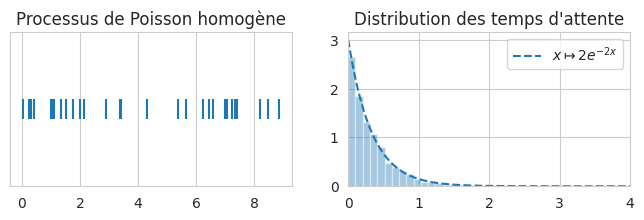

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8, 2))

mu = 3
data = poisson(T = 1000, mu=3)

num_samples = 30
axes[0].scatter(data[:num_samples], np.ones(num_samples),
                marker='|', c='C0', s=200)
axes[0].set_yticks([], [])
axes[0].set_title('Processus de Poisson homogène')

diff = np.diff(data, prepend=0)
axes[1].hist(diff, density=True, alpha=0.4, bins=30)
xlim = (0, 4)
axes[1].set_xlim(xlim)
x = np.linspace(0, xlim[-1], 1000)
axes[1].plot(x, mu * np.exp(-mu * x), c='C0', linestyle='--',
             label='$x \\mapsto 2e^{-2x}$')
axes[1].set_title('Distribution des temps d\'attente')

plt.legend()
plt.savefig('../images/poisson_process.png', bbox_inches='tight',
            transparent=True)

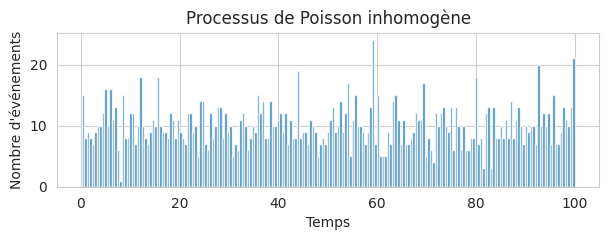

In [19]:
T = 100
mu = 20
seq = poisson_inh(T, mu)
plt.figure(figsize=(7, 2))
plt.hist(seq, bins=seq.size // 10, alpha=0.8, color='C0')
plt.xlabel('Temps')
plt.ylabel('Nombre d\'événements')
plt.title('Processus de Poisson inhomogène')
plt.savefig('../images/poisson_inh.png', bbox_inches='tight', transparent=True)

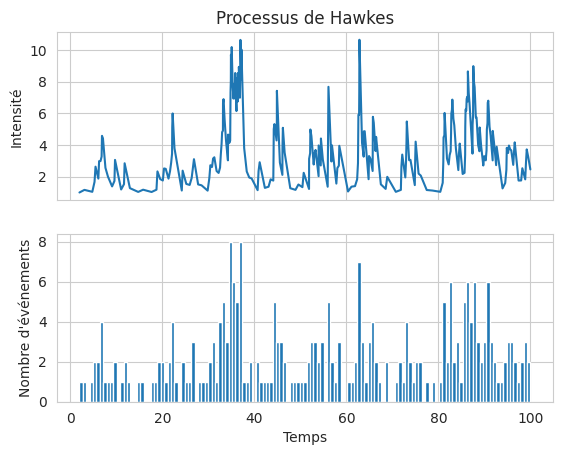

In [17]:
T = 100
alpha = 1
beta = 2
seq = hawkes(alpha=1, beta=2, T=T)
intensities = [intensity(s, seq) for s in seq]

# plt.figure(figsize=(8, 3))
# plt.plot(seq, intensities)
# plt.show()

fig, axes = plt.subplots(2, 1, sharex='col')
axes[0].plot(seq, intensities)
axes[0].set_ylabel('Intensité')
axes[0].set_title('Processus de Hawkes')
axes[1].hist(seq, bins=seq.size // 2)
axes[1].set_ylabel('Nombre d\'événements')
axes[1].set_xlabel('Temps')
plt.savefig('../images/hawkes.png', bbox_inches='tight', transparent=True)

### Descente de gradient avec JAX

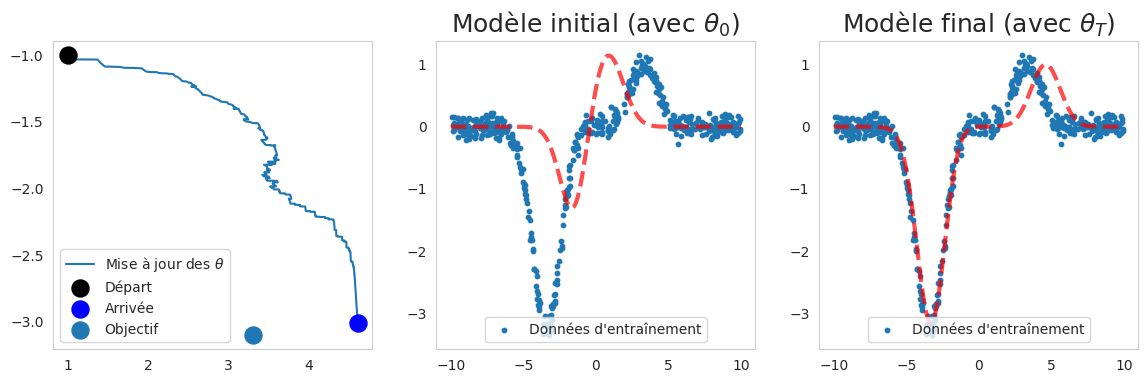

In [5]:
x_train, y_train = data_generation()
thetas = sgd(F, x_train, y_train, theta_0 = jnp.array([1., -1.]),
             lr=0.1, n_step=3000)
plot_sgd(F, x_train, y_train, thetas)
plt.savefig('../images/sgd.png', dpi=200, bbox_inches='tight')

### Génération de séquences

In [4]:
seq = etas(t_end=2000)
frame = to_frame(seq)
frame.tail()

,time,magnitude,parent
4555,1997.640043,0.616726,-1.0
4556,1999.182481,0.215136,-1.0
4557,1999.883330,0.061819,-1.0
4558,1999.970854,0.718900,-1.0
4559,1999.970854,0.653511,4558.0


In [5]:
frame.time

0          1.239328
1          4.245541
2          4.245582
3          4.913182
4          5.339214
           ...     
4555    1997.640043
4556    1999.182481
4557    1999.883330
4558    1999.970854
4559    1999.970854
Name: time, Length: 4560, dtype: float64

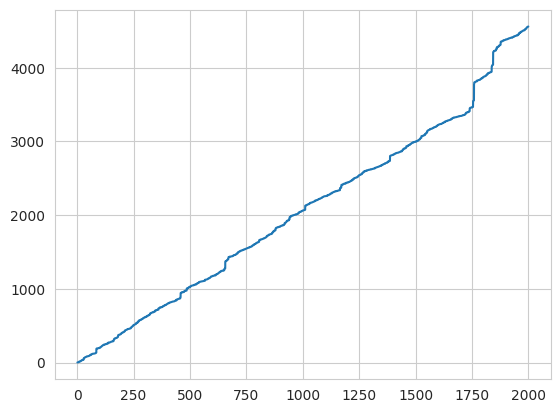

In [6]:
plt.plot(frame.time, frame.index + 1)
plt.show()

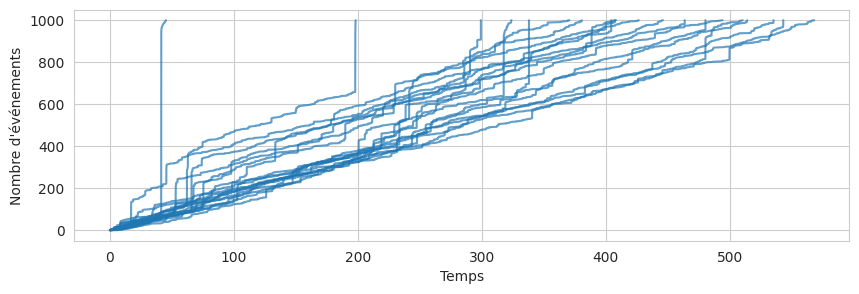

In [7]:
seqs = []
num_seqs = 20
plt.figure(figsize=(10, 3))
for k in range(num_seqs):
    seq = etas(max_len=1000)
    seqs.append(seq)
    plt.plot(seq[:, 0], np.arange(1, seq.shape[0] + 1), c='C0', alpha=0.7)
    print(f'Génération des séquences : {k + 1} \r', end='')
plt.xlabel('Temps')
plt.ylabel('Nombre d\'événements')
plt.savefig('../images/batch_etas.png', bbox_inches='tight', dpi=150)

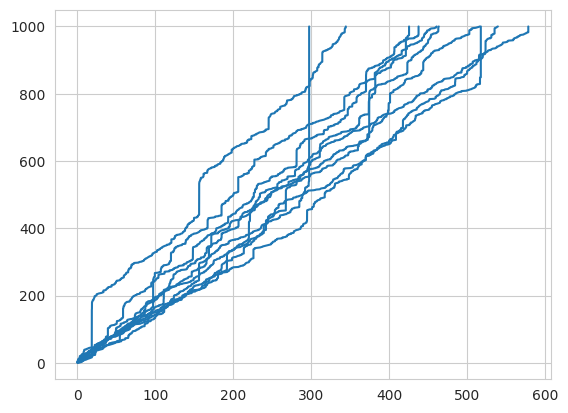

In [8]:
seqs = []
max_len = 1000
num_seqs = 10
for k in range(num_seqs):
    seq = etas(max_len=max_len)
    seqs.append(seq)
    plt.plot(seq[:, 0], np.arange(1, seq.shape[0] + 1), c='C0')
    print(f'Génération des séquences : {k + 1} \r', end='')
plt.show()

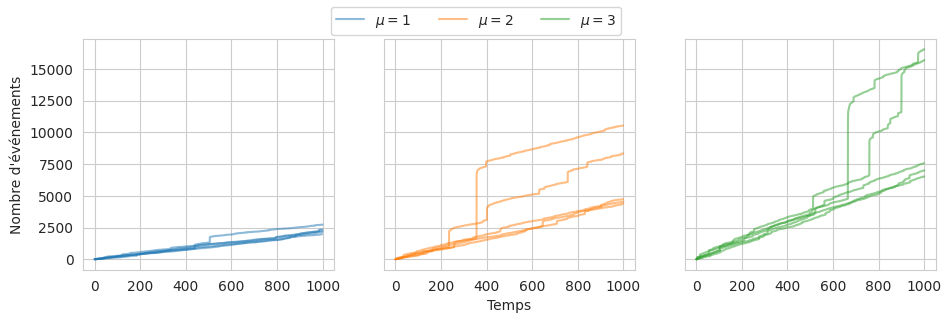

In [9]:
mu = [1, 2, 3]
fig, axes = plt.subplots(1, 3, sharey='row', figsize=(11, 3))
for i, (m, ax) in enumerate(zip(mu, axes)):
    for j in range(5):
        label=f'$\\mu = {m}$' if j == 0 else None
        seq = etas(t_end=1000, mu=m)
        ax.plot(seq[:, 0], np.arange(1, seq.shape[0] + 1),
                label=label, c=f'C{i}', alpha=0.5)
axes[0].set_ylabel('Nombre d\'événements')
axes[1].set_xlabel('Temps')
fig.legend(loc='upper center', ncol=3)
plt.savefig('../images/mu_etas.png', bbox_inches='tight', dpi=150)

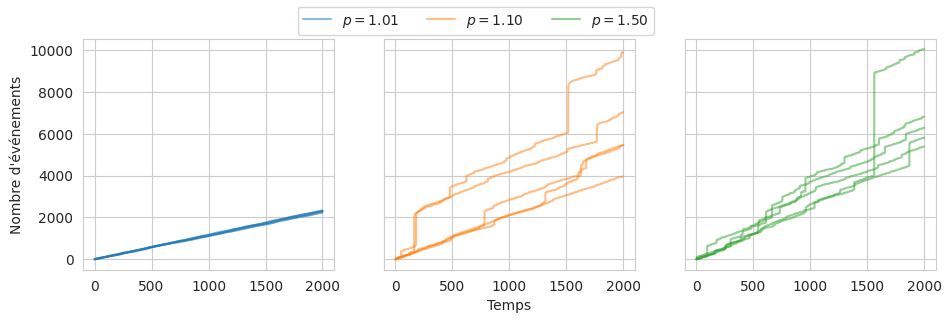

In [25]:
pl = [1.01, 1.1, 1.5]
fig, axes = plt.subplots(1, 3, sharey='row', figsize=(11, 3))
for i, (p, ax) in enumerate(zip(pl, axes)):
    for j in range(5):
        label = f'$p = {p:.2f}$' if j == 0 else None
        seq = etas(t_end=2000, p=p)
        ax.plot(seq[:, 0], np.arange(1, seq.shape[0] + 1),
                label=label, c=f'C{i}', alpha=0.5)

axes[0].set_ylabel('Nombre d\'événements')
axes[1].set_xlabel('Temps')
fig.legend(loc='upper center', ncol=3)
plt.savefig('p_etas.png', bbox_inches='tight', dpi=150)

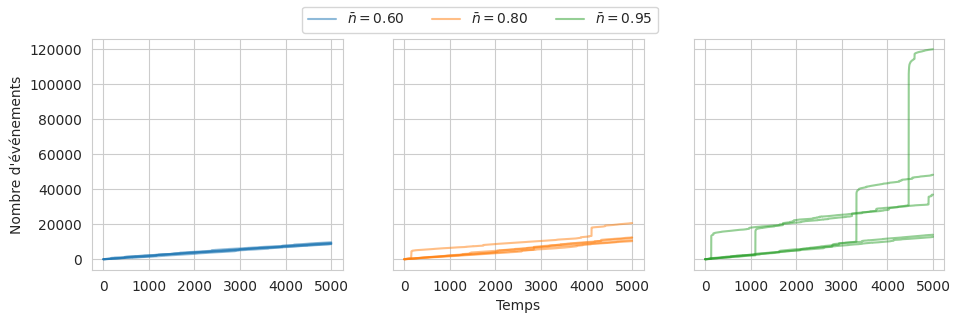

In [11]:
bar_n = [0.6, 0.8, 0.95]
fig, axes = plt.subplots(1, 3, sharey='row', figsize=(11, 3))
for i, (b, ax) in enumerate(zip(bar_n, axes)):
    for j in range(5):
        label = f'$\\bar{{n}} = {b:.2f}$' if j == 0 else None
        seq = etas(t_end=5000, bar_n=b)
        ax.plot(seq[:, 0], np.arange(1, seq.shape[0] + 1),
                label=label, c=f'C{i}', alpha=0.5)
axes[0].set_ylabel('Nombre d\'événements')
axes[1].set_xlabel('Temps')
fig.legend(loc='upper center', ncol=3)
plt.savefig('../images/bar_n_etas.png', bbox_inches='tight', dpi=150)

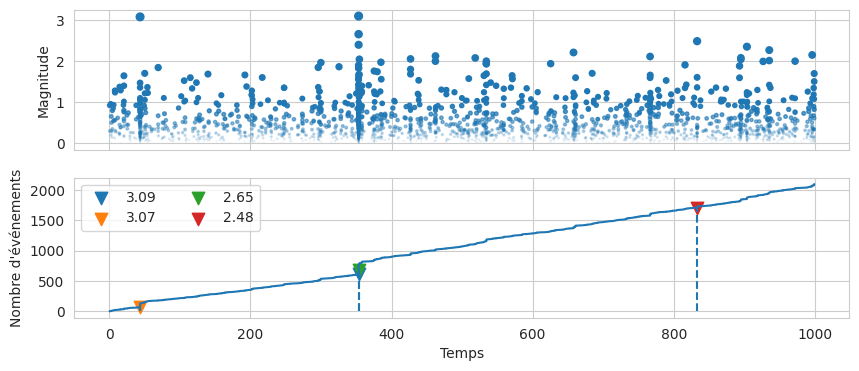

In [12]:
# On peut visualiser l'influence de la magnitude sur le nombre d'événements.

seq = etas(t_end=1000)
frame = to_frame(seq)
high_mags_idx = frame.magnitude.sort_values(ascending=False).index[:4]
fig, axes = plt.subplots(2, 1, figsize=(10, 4), sharex='col')
axes[0].scatter(frame.time, frame.magnitude, s=frame.magnitude * 10,
                alpha=np.clip(frame.magnitude, 0, 1))
axes[1].plot(frame.time, frame.index + 1)
for idx in high_mags_idx:
    t = frame.time.iloc[idx]
    m = frame.magnitude.iloc[idx]
    axes[1].vlines(t, 0, idx, cmap=plt.cm.binary, linestyle='--')
    axes[1].scatter(t, idx, s=80, label=round(m, 2), marker='v')
axes[1].set_xlabel('Temps')
axes[0].set_ylabel('Magnitude')
axes[1].set_ylabel('Nombre d\'événements')
axes[1].legend(ncol=2)
plt.savefig('../images/etas_sequence.png', dpi=150, bbox_inches='tight')
plt.show()

### Entraînement de modèles

In [170]:
# Le jeu de données est utilisé par Oleksandr Shchur dans son exemple.

with open('../data/shchur.pkl', 'rb') as f:
    inter_times, seq_lengths, t_end = pickle.load(f)
model = Model(C=32, dist=Weibull, R=1)
history = model.fit(inter_times, seq_lengths, t_end, 200, verbose=1)
model.save('../models/shchur_1_weibull.pkl')

Loss at epoch    1:    1.221
Loss at epoch   10:    0.820
Loss at epoch   20:    0.815
Loss at epoch   30:    0.808
Loss at epoch   40:    0.798
Loss at epoch   50:    0.792
Loss at epoch   60:    0.786
Loss at epoch   70:    0.781
Loss at epoch   80:    0.776
Loss at epoch   90:    0.772
Loss at epoch  100:    0.767
Loss at epoch  110:    0.763
Loss at epoch  120:    0.755
Loss at epoch  130:    0.738
Loss at epoch  140:    0.746
Loss at epoch  150:    0.737
Loss at epoch  160:    0.730
Loss at epoch  170:    0.726
Loss at epoch  180:    0.723
Loss at epoch  190:    0.737
Loss at epoch  200:    0.736


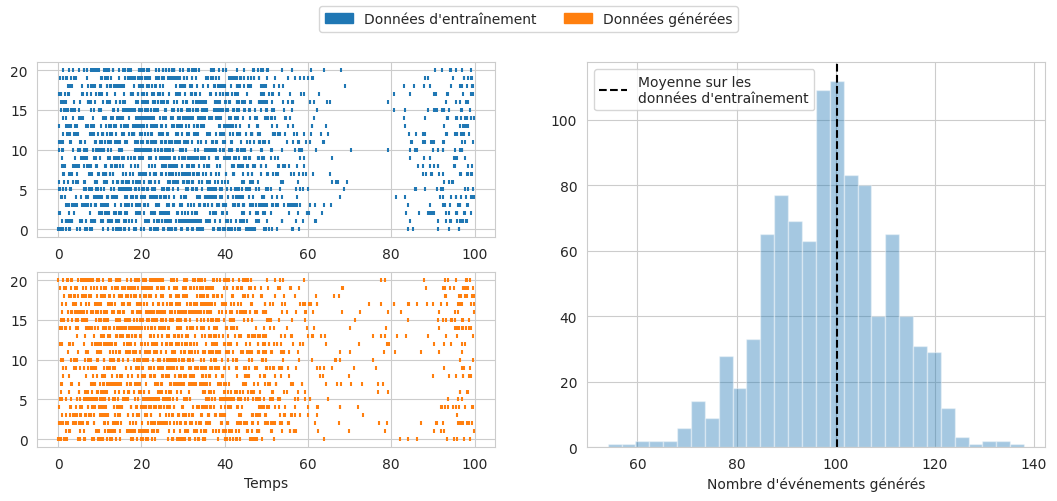

In [169]:
with open('../data/shchur.pkl', 'rb') as f:
    inter_times, seq_lengths, t_end = pickle.load(f)
model = Model.load('../models/shchur_1_weibull.pkl')

arrival_times = np.cumsum(inter_times, -1)
gen_arrival_times, gen_seq_lengths = model.generate(1000, t_end)

fig, axes = plt.subplot_mosaic([['top', 'right'], ['bottom', 'right']],
                               figsize=(13, 5))
for i, seq in enumerate(arrival_times):
    t = seq[:seq_lengths[i]]
    axes['top'].scatter(
        t, np.ones_like(t) * i, marker='|', s=10, c='C0')
    if i == 20:
        break
left_patch = mpatches.Patch(color='C0', label='Données d\'entraînement')

for i, seq in enumerate(gen_arrival_times):
    t = seq[:gen_seq_lengths[i]]
    axes['bottom'].scatter(
        t, np.ones_like(t) * i, marker='|', s=10, c='C1')
    if i == 20:
        break
right_patch = mpatches.Patch(color='C1', label='Données générées')

axes['right'].hist(gen_seq_lengths, bins=30, alpha=0.4)
axes['right'].axvline(x=np.mean(seq_lengths), color='black', linestyle='--',
                      label='Moyenne sur les\ndonnées d\'entraînement')
axes['right'].legend(loc='upper left')
axes['top'].sharex(axes['bottom'])
axes['bottom'].set_xlabel('Temps')
axes['right'].set_xlabel('Nombre d\'événements générés')
fig.legend(handles=[left_patch, right_patch], loc='upper center', ncol=2)
plt.savefig('../images/gen_data_1_weibull.png', dpi=150, bbox_inches='tight')

In [14]:
inter_times, seq_lengths, t_end = pickle.load(open('../data/shchur.pkl', 'rb'))
model = Model(C=32, dist=Gamma, R=3)
history = model.fit(inter_times, seq_lengths, t_end, 200, verbose=1)
model.save('../models/shchur_3_gamma.pkl')

Loss at epoch    1:    0.920
Loss at epoch   10:    0.807
Loss at epoch   20:    0.781
Loss at epoch   30:    0.770
Loss at epoch   40:    0.763
Loss at epoch   50:    0.760
Loss at epoch   60:    0.753
Loss at epoch   70:    0.742
Loss at epoch   80:    0.730
Loss at epoch   90:    0.723
Loss at epoch  100:    0.721
Loss at epoch  110:    0.715
Loss at epoch  120:    0.714
Loss at epoch  130:    0.714
Loss at epoch  140:    0.712
Loss at epoch  150:    0.710
Loss at epoch  160:    0.710
Loss at epoch  170:    0.710
Loss at epoch  180:    0.709
Loss at epoch  190:    0.715
Loss at epoch  200:    0.710


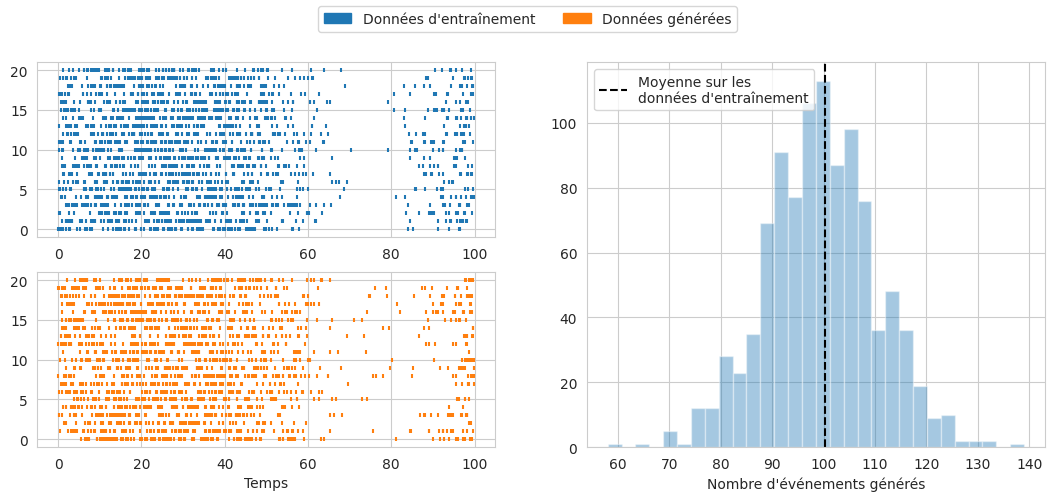

In [168]:
with open('../data/shchur.pkl', 'rb') as f:
    inter_times, seq_lengths, t_end = pickle.load(f)
model = Model.load('../models/shchur_3_gamma.pkl')

arrival_times = np.cumsum(inter_times, -1)
gen_arrival_times, gen_seq_lengths = model.generate(1000, t_end)

fig, axes = plt.subplot_mosaic([['top', 'right'], ['bottom', 'right']],
                               figsize=(13, 5))
for i, seq in enumerate(arrival_times):
    t = seq[:seq_lengths[i]]
    axes['top'].scatter(
        t, np.ones_like(t) * i, marker='|', s=10, c='C0')
    if i == 20:
        break
left_patch = mpatches.Patch(color='C0', label='Données d\'entraînement')

for i, seq in enumerate(gen_arrival_times):
    t = seq[:gen_seq_lengths[i]]
    axes['bottom'].scatter(
        t, np.ones_like(t) * i, marker='|', s=10, c='C1')
    if i == 20:
        break
right_patch = mpatches.Patch(color='C1', label='Données générées')

axes['right'].hist(gen_seq_lengths, bins=30, alpha=0.4)
axes['right'].axvline(x=np.mean(seq_lengths), color='black', linestyle='--',
                      label='Moyenne sur les\ndonnées d\'entraînement')
axes['right'].legend(loc='upper left')
axes['top'].sharex(axes['bottom'])
axes['bottom'].set_xlabel('Temps')
axes['right'].set_xlabel('Nombre d\'événements générés')
fig.legend(handles=[left_patch, right_patch], loc='upper center', ncol=2)
plt.savefig('../images/gen_data_3_gamma.png', dpi=150, bbox_inches='tight')

In [27]:
# Génère un jeu de données avec des temps d'attente distribués selon une
# loi de Weibull classique.

b = 2
k = 3
arrival_times = np.cumsum(Weibull(b, k).sample([100, 250]), -1)
t_end = np.min(arrival_times[:, -1]) - 10
seq_lengths = np.sum(arrival_times < t_end, -1)
inter_times, _, seq_lengths, _ = create_training_dataset(
    [np.stack([s[:l], s[:l]], -1) for s, l in zip(arrival_times, seq_lengths)],
    t_end
)

model = Model(C=32, dist=Weibull, R=1)
history = model.fit(inter_times, seq_lengths, t_end, epochs=250,
                    return_distributions=True, verbose=1)
model.save('../models/toy_model_inter_times_weibull.pkl')
with open('../data/toy_dataset_inter_times_weibull.pkl', 'wb') as f:
    pickle.dump([inter_times, seq_lengths, t_end], f)

Loss at epoch    1:    1.530
Loss at epoch   10:    0.275
Loss at epoch   20:    0.136
Loss at epoch   30:    0.126
Loss at epoch   40:    0.104
Loss at epoch   50:    0.102
Loss at epoch   60:    0.100
Loss at epoch   70:    0.099
Loss at epoch   80:    0.098
Loss at epoch   90:    0.098
Loss at epoch  100:    0.097
Loss at epoch  110:    0.097
Loss at epoch  120:    0.096
Loss at epoch  130:    0.096
Loss at epoch  140:    0.096
Loss at epoch  150:    0.095
Loss at epoch  160:    0.095
Loss at epoch  170:    0.095
Loss at epoch  180:    0.094
Loss at epoch  190:    0.094
Loss at epoch  200:    0.094
Loss at epoch  210:    0.093
Loss at epoch  220:    0.093
Loss at epoch  230:    0.093
Loss at epoch  240:    0.093
Loss at epoch  250:    0.093


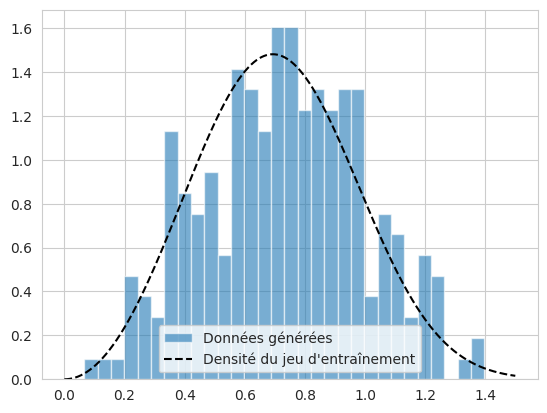

In [33]:
# Chargement et visualisation

model = Model.load('../models/toy_model_inter_times_weibull.pkl')
with open('../data/toy_dataset_inter_times_weibull.pkl', 'rb') as f:
    inter_times, seq_lengths, t_end = pickle.load(f)
arrival_times = np.cumsum(inter_times, -1)
gen_arrival_times, gen_seq_lengths = model.generate(1000, t_end)

plt.hist(np.diff(gen_arrival_times[0], prepend=0),
         density=True, bins=30, alpha=0.6, label='Données générées')
x = np.linspace(0, 1.5, 1000)
plt.plot(x, Weibull(b, k).prob(x), c='black',
         linestyle='--', label='Densité du jeu d\'entraînement')
plt.legend(loc='best', ncol=1)
plt.savefig('../images/inter_times_density_training.png',
            bbox_inches='tight', dpi=150)

### Convergence des paramètres

Loss at epoch    1:    1.715
Loss at epoch   10:    0.608
Loss at epoch   20:    0.199
Loss at epoch   30:    0.149
Loss at epoch   40:    0.120
Loss at epoch   50:    0.115
Loss at epoch   60:    0.115
Loss at epoch   70:    0.113
Loss at epoch   80:    0.112
Loss at epoch   90:    0.111
Loss at epoch  100:    0.111


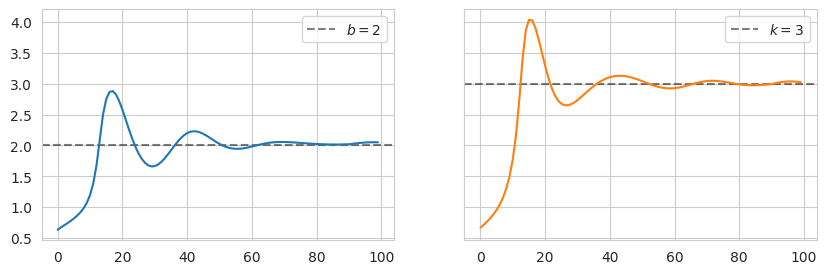

In [35]:
# On entraîne un moèle sur un jeu de données et on 
# récupère les distributions obtenues à chaque epoch (les données
# suivent une loi de Weibull).

b = 2
k = 3
arrival_times = np.cumsum(Weibull(b, k).sample([100, 150]), -1)
t_end = np.min(arrival_times[:, -1]) - 10
seq_lengths = np.sum(arrival_times < t_end, -1)
inter_times, _, seq_lengths, _ = create_training_dataset(
    [np.stack([s[:l], s[:l]], -1) for s, l in zip(arrival_times, seq_lengths)],
    t_end
)

model = Model(C=32, dist=Weibull, R=1)
history = model.fit(inter_times, seq_lengths, t_end, epochs=100,
                    return_distributions=True, verbose=1)

distributions = history['distributions']
params = [d.params[1] for d in distributions]
params = np.squeeze(np.stack(params, 0), -2)

fig, axes = plt.subplots(1, 2, sharey='row', figsize=(10, 3))

axes[0].axhline(y=b, label=f'$b = {b}$', c='black', linestyle='--', alpha=0.5)
axes[0].legend()
axes[1].axhline(y=k, label=f'$k = {k}$', c='black', linestyle='--', alpha=0.5)
axes[1].legend()

num_epochs = len(distributions)
last_idx = enumerate(seq_lengths)

b_mean_per_epoch = [np.mean(params[i, ..., 0][range(100), seq_lengths])
                    for i in range(num_epochs)]
axes[0].plot(range(num_epochs), b_mean_per_epoch, c='C0')

k_mean_per_epoch = [np.mean(params[i, ..., 1][range(100), seq_lengths])
                      for i in range(num_epochs)]
axes[1].plot(range(num_epochs), k_mean_per_epoch, c='C1')

plt.savefig('../images/weibull_cvg.png', bbox_inches='tight', dpi=150)
plt.show()

Loss at epoch    1:    1.105
Loss at epoch   10:    0.803
Loss at epoch   20:    0.755
Loss at epoch   30:    0.732
Loss at epoch   40:    0.730
Loss at epoch   50:    0.727
Loss at epoch   60:    0.730
Loss at epoch   70:    0.726
Loss at epoch   80:    0.726
Loss at epoch   90:    0.725
Loss at epoch  100:    0.725


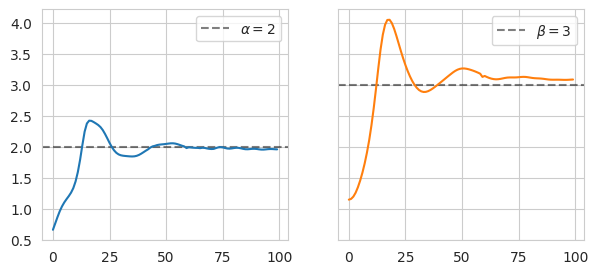

In [39]:
# On refait la même chose avec des données qui suivent une loi Gamma.

alpha = 2
beta = 3
arrival_times = np.cumsum(tfd.Gamma(alpha, beta).sample([300, 250]), -1)
t_end = np.min(arrival_times[:, -1]) - 10
seq_lengths = np.sum(arrival_times < t_end, -1)
inter_times, _, seq_lengths, _ = create_training_dataset(
    [np.stack([s[:l], s[:l]], -1) for s, l in zip(arrival_times, seq_lengths)],
    t_end
)

model = Model(C=32, dist=Gamma, R=1)
history = model.fit(inter_times, seq_lengths, t_end, epochs=100,
                    return_distributions=True, verbose=1)

distributions = history['distributions']
params = [d.params[1] for d in distributions]
params = np.squeeze(np.stack(params, 0), -2)

fig, axes = plt.subplots(1, 2, sharey='row', figsize=(7, 3))

axes[0].axhline(y=alpha, label=f'$\\alpha = {alpha}$',
                linestyle='--', c='black', alpha=0.5)
axes[0].legend()
axes[1].axhline(y=beta, label=f'$\\beta = {beta}$',
                linestyle='--', c='black', alpha=0.5)
axes[1].legend()

num_epochs = len(distributions)
last_idx = list(enumerate(seq_lengths))

alpha_mean_per_epoch = [np.mean(params[i, ..., 0][last_idx])
                    for i in range(num_epochs)]
axes[0].plot(range(num_epochs), alpha_mean_per_epoch, c='C0')

beta_mean_per_epoch = [np.mean(params[i, ..., 1][last_idx])
                      for i in range(num_epochs)]
axes[1].plot(range(num_epochs), beta_mean_per_epoch, c='C1')

plt.savefig('../images/gamma_cvg.png', bbox_inches='tight', dpi=150)
plt.show()

### Approximation de mélanges

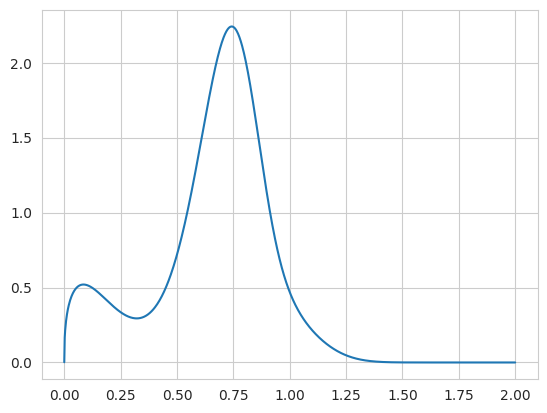

In [175]:
n_comp = np.random.randint(3, 10)
weights = tf.nn.softmax(np.random.uniform(size=n_comp))
b = np.random.uniform(0.5, 9, size=n_comp)
k = np.random.uniform(0.5, 9, size=n_comp)
mix = Mixture(weights, Weibull(b, k))

x = np.linspace(0, 2, 1000)
plt.plot(x, mix.prob(x))
plt.show()

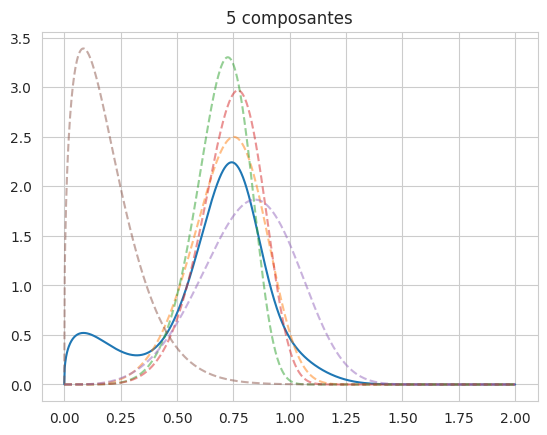

In [177]:
mix = Mixture(weights, Weibull(b, k))
comps = Weibull(b, k)

x = np.linspace(0, 2, 1000)
plt.plot(x, mix.prob(x))
plt.plot(x, comps.prob(x[..., tf.newaxis]), linestyle='--', alpha=0.5)
plt.title(f'{weights.shape[0]} composantes')
plt.savefig('../images/mixture_weibull.png', bbox_inches='tight')
plt.show()

In [178]:
tau = mix.sample(251)
t = np.cumsum(tau)
t_end = t[-1]
t = t[:-1]

model = Model(32, dist=Weibull, R=10, strategy='tau_log_tau')
history = model.fit([tau], [t.size], t_end, 200, return_distributions=True)

Loss at epoch    1:    1.572
Loss at epoch   10:    0.713
Loss at epoch   20:    0.145
Loss at epoch   30:   -0.102
Loss at epoch   40:   -0.114
Loss at epoch   50:   -0.134
Loss at epoch   60:   -0.136
Loss at epoch   70:   -0.140
Loss at epoch   80:   -0.143
Loss at epoch   90:   -0.147
Loss at epoch  100:   -0.150
Loss at epoch  110:   -0.154
Loss at epoch  120:   -0.158
Loss at epoch  130:   -0.163
Loss at epoch  140:   -0.169
Loss at epoch  150:   -0.176
Loss at epoch  160:   -0.183
Loss at epoch  170:   -0.191
Loss at epoch  180:   -0.200
Loss at epoch  190:   -0.211
Loss at epoch  200:   -0.145


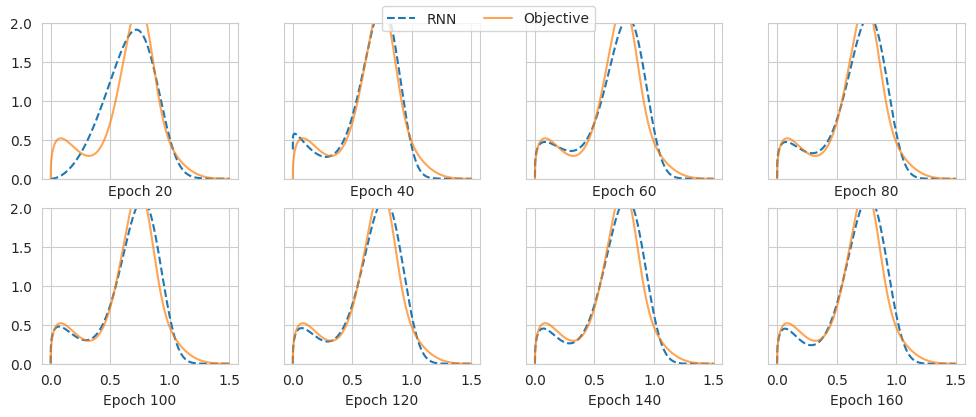

In [181]:
fig, axes = plt.subplots(2, 4, figsize=(10, 4), sharex=True, sharey=True)
fig.tight_layout()
dists = history['distributions']
i = 0
x = np.linspace(0, 1.5, 1000)
for j, ax in enumerate(axes.ravel()):
    i += 20
    recast_dist = get_dist_at_epoch(i - 1, dists)
    label1 = 'RNN' if j == 1 else None
    label2 = 'Objective' if j == 1 else None
    ax.plot(x, recast_dist.prob(x), linestyle='--', label=label1)
    ax.plot(x, mix.prob(x), alpha=0.7, label=label2)
    ax.set_xlabel(f'Epoch {i}')
    ax.set_ylim((0, 2))
fig.legend(loc='upper center', ncol=2)
plt.savefig('../images/mix_1.png', bbox_inches='tight', dpi=150)
plt.show()

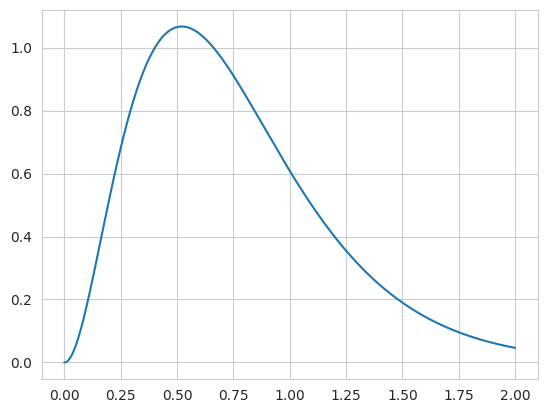

In [196]:
# n_comp = np.random.randint(3, 10)
n_comp = 1
weights = tf.nn.softmax(np.random.uniform(size=n_comp))
b = np.random.uniform(0.5, 9, size=n_comp)
k = np.random.uniform(0.5, 9, size=n_comp)
mix = Mixture(weights, Gamma(b, k))

x = np.linspace(0, 2, 1000)
plt.plot(x, mix.prob(x))
plt.show()

In [201]:
tau = mix.sample(501)
t = np.cumsum(tau)
t_end = t[-1]
t = t[:-1]

model = Model(32, dist=Gamma, R=1, strategy='tau_log_tau')
history = model.fit([tau], [t.size], t_end, 200, return_distributions=True)

Loss at epoch    1:    1.270
Loss at epoch   10:    0.865
Loss at epoch   20:    0.628
Loss at epoch   30:    0.604
Loss at epoch   40:    0.595
Loss at epoch   50:    0.594
Loss at epoch   60:    0.592
Loss at epoch   70:    0.591
Loss at epoch   80:    0.590
Loss at epoch   90:    0.590
Loss at epoch  100:    0.589
Loss at epoch  110:    0.588
Loss at epoch  120:    0.587
Loss at epoch  130:    0.586
Loss at epoch  140:    0.584
Loss at epoch  150:    0.582
Loss at epoch  160:    0.578
Loss at epoch  170:    0.574
Loss at epoch  180:    0.568
Loss at epoch  190:    0.561
Loss at epoch  200:    0.555


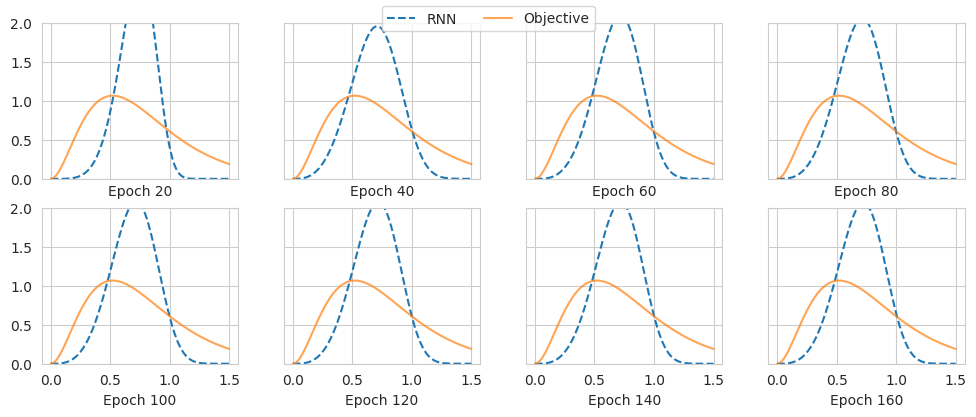

In [202]:
fig, axes = plt.subplots(2, 4, figsize=(10, 4), sharex=True, sharey=True)
fig.tight_layout()
dists = history['distributions']
i = 0
x = np.linspace(0, 1.5, 1000)
for j, ax in enumerate(axes.ravel()):
    i += 20
    recast_dist = get_dist_at_epoch(i - 1, dists)
    label1 = 'RNN' if j == 1 else None
    label2 = 'Objective' if j == 1 else None
    ax.plot(x, recast_dist.prob(x), linestyle='--', label=label1)
    ax.plot(x, mix.prob(x), alpha=0.7, label=label2)
    ax.set_xlabel(f'Epoch {i}')
    ax.set_ylim((0, 2))
fig.legend(loc='upper center', ncol=2)
plt.savefig('../images/mix_1.png', bbox_inches='tight', dpi=150)
plt.show()

### Entraînement avec des séquences ETAS et génération

In [54]:
seqs, (inter_times, magnitudes, seq_lengths, t_end) = generate_dataset(
    batch_size=100, max_len=250, t_end=100)

model = Model(C=32, dist=Gamma, R=32, dropout_rate=0.5, strategy='log_tau')
history = model.fit(inter_times, seq_lengths, t_end, 1000,
                    magnitudes, verbose=0)

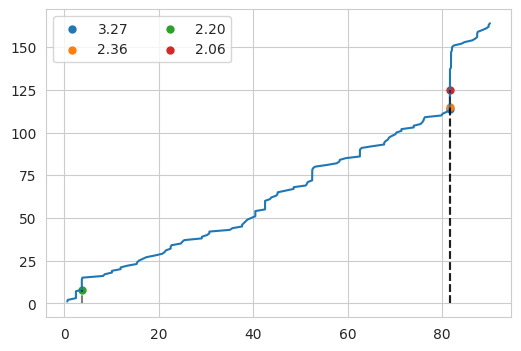

In [59]:
generated_data, seq_lengths = model.generate(1, np.mean(t_end))
plot_etas_seq(get_seq(generated_data, seq_lengths, 0), 4)

### La distribution du prochain temps d'attente

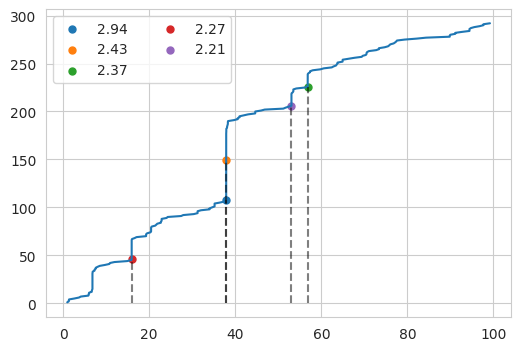

In [60]:
seq = to_frame(etas(t_end=100))
plot_etas_seq(seq, 5)

In [65]:
idx = seq.magnitude.sort_values(ascending=False).iloc[:5].sort_index().index
first_mag_idx = idx[0]
seq.iloc[:first_mag_idx + 1].tail(10)

,time,magnitude,parent
36,7.561034,0.062564,35.0
37,7.986727,1.285480,-1.0
38,8.496833,1.124633,-1.0
39,9.731571,0.003078,-1.0
40,10.739679,0.027569,-1.0
41,10.878507,0.389983,-1.0
42,11.912887,0.756065,-1.0
43,14.869448,0.701683,-1.0
44,15.845741,0.037002,-1.0
45,15.921104,2.268458,-1.0


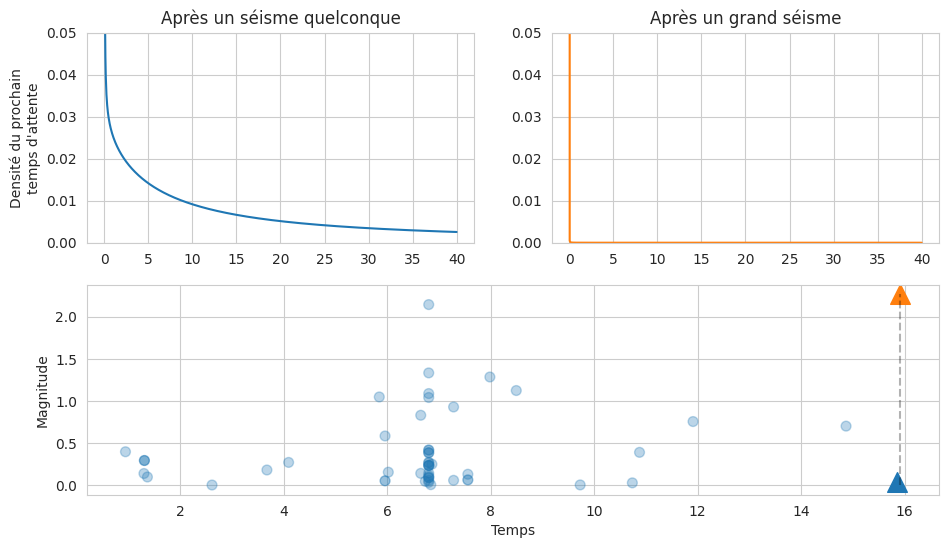

In [90]:
fig, axes = plt.subplot_mosaic([['left', 'right'], ['bottom', 'bottom']],
                               figsize=(11, 6))

subset = seq.iloc[:first_mag_idx + 1]
t = subset.time.to_numpy()
m = subset.magnitude.to_numpy()

dist_0 = ETAS(t[:-1], m[:-1])
pdf_0 = dist_0.density
x = np.linspace(0, 40, 1000)
axes['left'].plot(x, pdf_0(x), c='C0')
axes['left'].set_ylim([0, 0.05])
axes['left'].set_ylabel('Densité du prochain\ntemps d\'attente')
axes['left'].set_title('Après un séisme quelconque')

dist_1 = ETAS(t, m)
pdf_1 = dist_1.density
axes['right'].plot(x, pdf_1(x), c='C1')
axes['right'].set_title('Après un grand séisme')

axes['right'].sharex(axes['left'])
axes['right'].sharey(axes['left'])

n_before = 100
size = 50
size_le = size * 4
marker = '^'

axes['bottom'].scatter(t[-n_before:-2], m[-n_before:-2],
                       s=size, alpha=np.maximum(0.3, m[-30:-2] / np.max(m)))
axes['bottom'].vlines(t[-1], 0, m[-1],
                      linestyle='--', colors='black', alpha=0.3)
axes['bottom'].scatter(t[-1], m[-1], c='C1', s=size_le, marker=marker)
axes['bottom'].scatter(t[-2], m[-2], c='C0', s=size_le, marker=marker)
axes['bottom'].set_ylabel('Magnitude')
axes['bottom'].set_xlabel('Temps')

plt.savefig('../images/etas_dist.png', bbox_inches='tight', dpi=150)

### Prédictions

In [97]:
seqs, (inter_times, magnitudes, seq_lengths, t_end) = generate_dataset(
    100, t_end=100, max_len=150, verbose=True)

model = Model(C=32, dist=Weibull, R=10, dropout_rate=0.5, strategy='log_tau')
history = model.fit(inter_times, seq_lengths, t_end, 200, magnitudes)

Generating sequences: 100/100
Loss at epoch    1:   -6.417
Loss at epoch   10:   -8.938
Loss at epoch   20:   -9.342
Loss at epoch   30:   -9.530
Loss at epoch   40:   -9.656
Loss at epoch   50:   -9.779
Loss at epoch   60:   -9.900
Loss at epoch   70:  -10.044
Loss at epoch   80:  -10.182
Loss at epoch   90:  -10.294
Loss at epoch  100:  -10.395
Loss at epoch  110:  -10.455
Loss at epoch  120:   -6.761
Loss at epoch  130:  -10.555
Loss at epoch  140:  -10.608
Loss at epoch  150:  -10.626
Loss at epoch  160:  -10.678
Loss at epoch  170:  -10.720
Loss at epoch  180:  -10.748
Loss at epoch  190:  -10.763
Loss at epoch  200:  -10.787


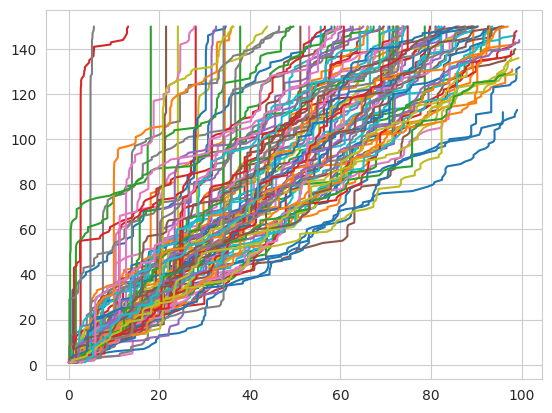

In [98]:
plot_seqs(seqs)

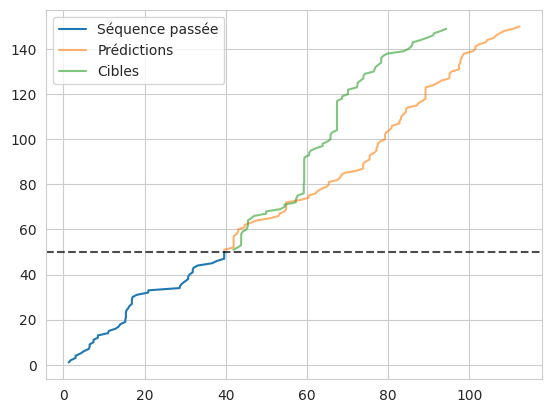

In [99]:
seq = seqs[0]
new_seq = predict_and_plot(model, seq, n_before=100)

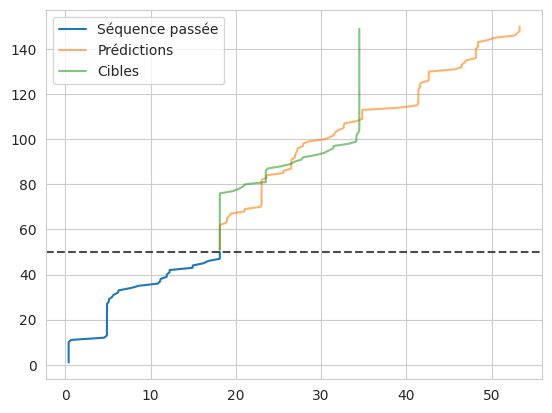

In [100]:
seq = seqs[1]
new_seq = predict_and_plot(model, seq, n_before=100)

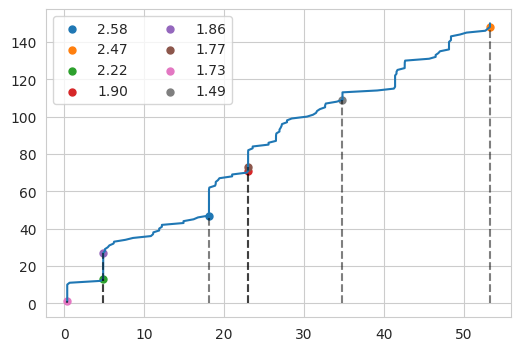

In [112]:
plot_etas_seq(to_frame(new_seq), 8)

### Comparaison des distributions

In [104]:
seqs, (inter_times, magnitudes, seq_lengths, t_end) = generate_dataset(
    100, t_end=100, max_len=150, verbose=True)

model = Model(C=32, dist=Gamma, R=1, dropout_rate=0.5, strategy='log_tau')
history = model.fit(inter_times, seq_lengths, t_end, 200, magnitudes)

Generating sequences: 100/100
Loss at epoch    1:    0.058
Loss at epoch   10:   -7.983
Loss at epoch   20:   -8.515
Loss at epoch   30:   -8.680
Loss at epoch   40:   -8.857
Loss at epoch   50:   -8.966
Loss at epoch   60:   -9.073
Loss at epoch   70:   -9.112
Loss at epoch   80:   -9.145
Loss at epoch   90:   -9.176
Loss at epoch  100:   -9.199
Loss at epoch  110:   -9.219
Loss at epoch  120:   -9.234
Loss at epoch  130:   -9.262
Loss at epoch  140:   -9.280
Loss at epoch  150:   -9.285
Loss at epoch  160:   -9.293
Loss at epoch  170:   -9.294
Loss at epoch  180:   -9.304
Loss at epoch  190:   -9.309
Loss at epoch  200:   -9.309


In [105]:
seq = seqs[0]
to_frame(seq).magnitude.sort_values(ascending=False).iloc[:5]

34     2.589529
109    2.460045
3      2.163838
69     2.031995
18     1.917300
Name: magnitude, dtype: float64

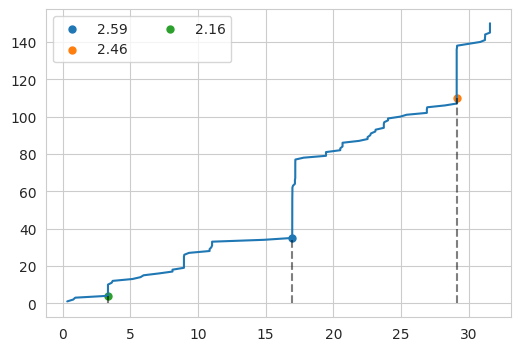

In [107]:
plot_etas_seq(to_frame(seq), 3, dpi=100)

In [109]:
to_frame(seq).iloc[30:100]

,time,magnitude,parent
30,11.041133,0.238912,23.0
31,11.041133,0.542836,30.0
32,11.041205,0.035533,31.0
33,14.880051,0.072129,-1.0
34,16.958530,2.589529,-1.0
...,...,...,...
95,23.721886,0.031894,93.0
96,23.750794,0.024609,93.0
97,24.031518,1.038226,-1.0
98,24.031518,0.586408,97.0


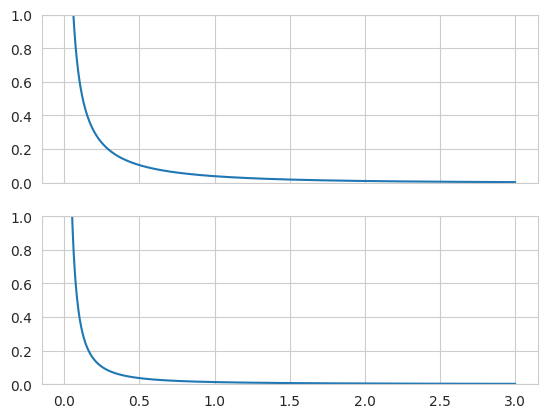

In [110]:
sub_seq = seq[:61]
t = sub_seq[:, 0]
m = sub_seq[:, 1]

recast_dist = model.predict(t, m, 1, True)[1][0]
etas_dist = ETAS(t, m)

fig, axes = plt.subplots(2, 1, sharex='col', sharey='col')
x = np.linspace(0, 3, 1000)
axes[0].plot(x, recast_dist.prob(x))
axes[1].plot(x, etas_dist.prob(x))
axes[1].set_ylim([0, 1])

plt.show()

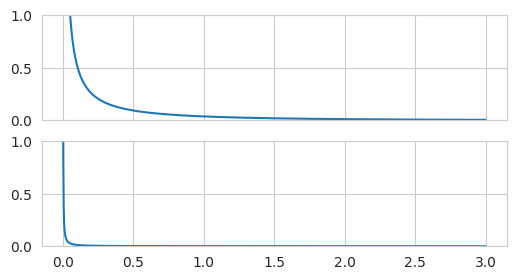

In [111]:
cmp_dist(model, seq, 20)

### Convergence de la log-vraisemblance

In [135]:
seqs, (inter_times, magnitudes, seq_lengths, t_end) = generate_dataset(
    batch_size=1, t_end=500
)
print(seqs[0].shape)
etas_log_like = log_likelihood(seqs[0], t_end)
print(etas_log_like)


(1221, 3)
13.513204087410966


In [136]:
model = Model(R=10, learning_rate=1e-3, strategy='log_tau')
history = model.fit(inter_times, seq_lengths,
                    t_end, 500, magnitudes, verbose=1)

Loss at epoch    1:   -8.768
Loss at epoch   10:  -10.243
Loss at epoch   20:  -11.161
Loss at epoch   30:  -11.630
Loss at epoch   40:  -11.940
Loss at epoch   50:  -12.169
Loss at epoch   60:  -12.317
Loss at epoch   70:  -12.438
Loss at epoch   80:  -12.528
Loss at epoch   90:  -12.603
Loss at epoch  100:  -12.668
Loss at epoch  110:  -12.727
Loss at epoch  120:  -12.780
Loss at epoch  130:  -12.827
Loss at epoch  140:  -12.867
Loss at epoch  150:  -12.903
Loss at epoch  160:  -12.935
Loss at epoch  170:  -12.964
Loss at epoch  180:  -12.992
Loss at epoch  190:  -13.020
Loss at epoch  200:  -13.047
Loss at epoch  210:  -13.074
Loss at epoch  220:  -13.098
Loss at epoch  230:  -13.121
Loss at epoch  240:  -13.143
Loss at epoch  250:  -13.160
Loss at epoch  260:  -13.174
Loss at epoch  270:  -13.190
Loss at epoch  280:  -13.205
Loss at epoch  290:  -13.219
Loss at epoch  300:  -13.233
Loss at epoch  310:  -13.246
Loss at epoch  320:  -13.258
Loss at epoch  330:  -13.270
Loss at epoch 

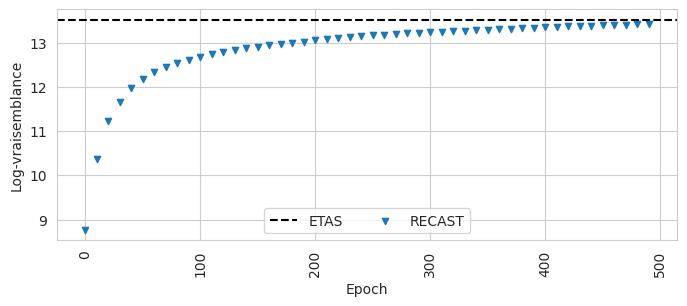

In [137]:
recast_log_like = -np.array(history['loss'])[::10]
x = range(len(recast_log_like))
plt.figure(figsize=(8, 3))
plt.axhline(y=etas_log_like, linestyle='--', c='black', label='ETAS')
plt.scatter(x, recast_log_like, label='RECAST', marker='v', s=20)
plt.legend(ncol=2, loc='lower center')
plt.ylabel('Log-vraisemblance')
plt.xticks(ticks=range(0, 51, 10), labels=range(0, 501, 100), rotation=90)
plt.xlabel('Epoch')
plt.savefig('../images/log_like_cvg.png', bbox_inches='tight', dpi=150)
plt.show()

### Nouvelles prédictions

In [139]:
seqs, (inter_times, magnitudes, seq_lengths, t_end) = generate_dataset(
    100, t_end=100, max_len=250, verbose=True)

model = Model(C=32, dist=Weibull, R=3, dropout_rate=.4, strategy='log_tau')
history = model.fit(inter_times, seq_lengths, t_end, 200, magnitudes)

Generating sequences: 100/100
Loss at epoch    1:   -5.419
Loss at epoch   10:   -7.961
Loss at epoch   20:   -8.586
Loss at epoch   30:   -8.842
Loss at epoch   40:   -9.013
Loss at epoch   50:   -9.157
Loss at epoch   60:   -9.257
Loss at epoch   70:   -9.363
Loss at epoch   80:   -9.440
Loss at epoch   90:   -9.505
Loss at epoch  100:   -9.559
Loss at epoch  110:   -9.616
Loss at epoch  120:   -9.651
Loss at epoch  130:   -9.682
Loss at epoch  140:   -9.712
Loss at epoch  150:   -9.738
Loss at epoch  160:   -9.768
Loss at epoch  170:   -9.788
Loss at epoch  180:   -9.809
Loss at epoch  190:   -9.832
Loss at epoch  200:   -9.854


In [140]:
np.mean(seq_lengths)

198.55

In [141]:
np.mean(t_end)

96.3927402761484

In [142]:
gen_data, seq_lengths = model.generate(1000, 100)

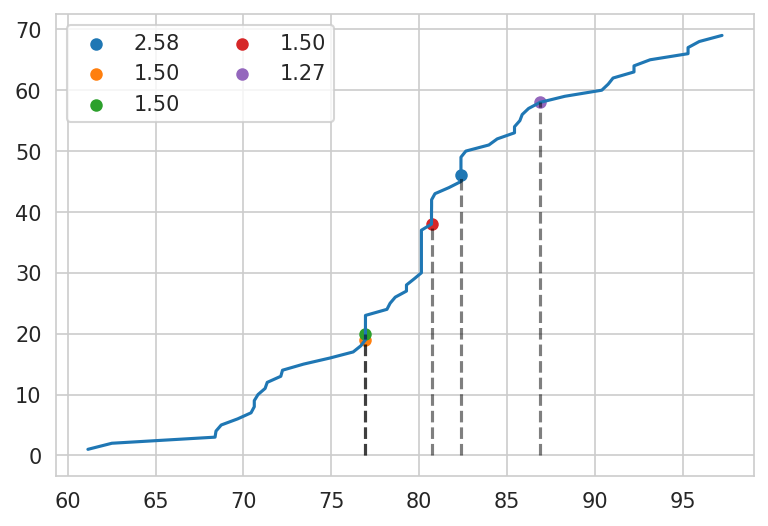

In [143]:
plot_etas_seq(to_frame(gen_data[0][:seq_lengths[0]]), 5, dpi=150)

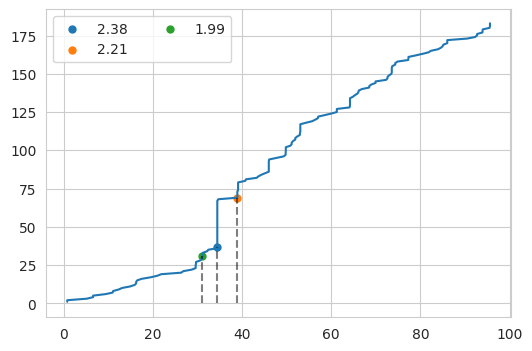

In [144]:
seq = etas(t_end=np.mean(t_end))
plot_etas_seq(to_frame(seq), 3)

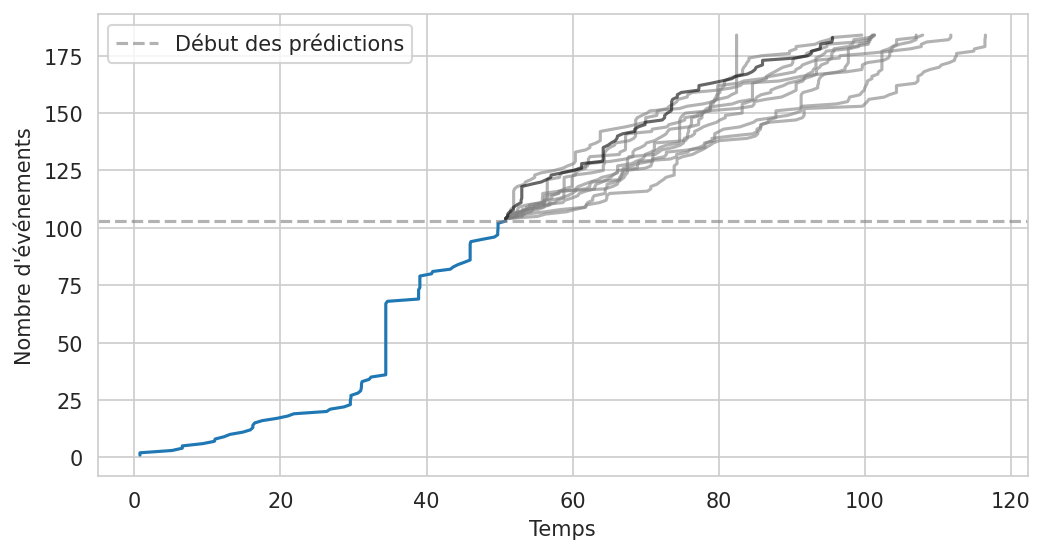

In [147]:
n_before = 80
n_after = 80
n_preds = n_after if n_after else n_before

past_seq = seq[:-n_before]

fig, ax = plt.subplots(dpi=150, figsize=(8, 4))

t = past_seq[:, 0]
m = past_seq[:, 1]
for i in range(10):
    preds = model.predict(t, m, n_preds)
    t_preds = np.concatenate([[t[-1]], preds[:, 0]])
    m_preds = preds[:, 1]
    ax.plot(t_preds, t.size + cumsum(t_preds), c='gray', alpha=0.6)

seq_size = seq.shape[0]
last_idx_target = min(seq_size - 1, seq_size - n_before + n_preds)
t_targets = seq[-n_before - 1:last_idx_target, 0]

ax.plot(t, cumsum(t))
ax.plot(t_targets, t.size + cumsum(t_targets), alpha=0.6, c='black')
ax.axhline(y=t.size, linestyle='--', c='gray',
           alpha=0.6, label='Début des prédictions')
ax.legend()
ax.set_xlabel('Temps')
ax.set_ylabel('Nombre d\'événements')
plt.savefig('../images/etas_preds.png', bbox_inches='tight', dpi=150)

In [148]:
to_frame(seq).magnitude.sort_values()

175    0.002637
155    0.006514
170    0.010067
27     0.011053
101    0.012680
         ...   
85     1.674573
62     1.760226
30     1.993371
68     2.211082
36     2.376777
Name: magnitude, Length: 183, dtype: float64

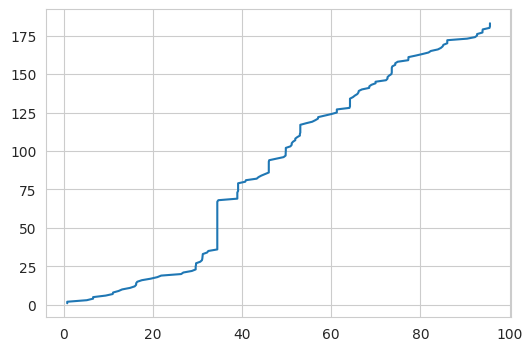

In [163]:
plot_etas_seq(to_frame(seq))

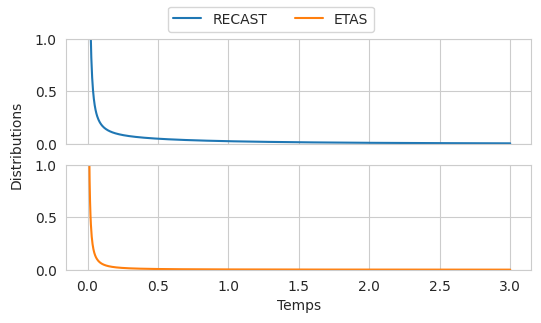

In [167]:
start = 10
sub_seq = seq[:50]
t = sub_seq[:, 0]
m = sub_seq[:, 1]

recast_dist = model.predict(t, m, 1, True)[1][0]
etas_dist = ETAS(t, m)

fig, axes = plt.subplots(2, 1, sharex='col', sharey='col', figsize=(6, 3))
x = np.linspace(0, 3, 1000)
axes[0].plot(x, recast_dist.prob(x), label='RECAST')
axes[1].plot(x, etas_dist.prob(x), label='ETAS', c='C1')
axes[1].set_ylim((0, 1))
axes[1].set_xlabel('Temps')
plt.text(-0.55, 0.8, 'Distributions', rotation=90.)
fig.legend(loc='upper center', ncol=2)

plt.savefig('../images/dist_etas_recast_2.png', dpi=150, bbox_inches='tight')